***
### Import of required libraries
***

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

from traffic.core import Traffic

2024-05-31 16:22:34.987126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:22:35.148320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:22:35.148352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:22:35.148915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 16:22:35.222567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:22:35.224636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

***
### Import of data, models and scalers
***

##### Data

In [3]:
test_in_con = np.load("/mnt/beegfs/store/krum/MT/samples/test_in32_con.npy")
test_in_var = np.load("/mnt/beegfs/store/krum/MT/samples/test_in32_var.npy")
test_out = np.load("/mnt/beegfs/store/krum/MT/samples/test_out32.npy")

# temp, to be removed -> change from 36 to 37 timesteps
test_out = test_out[:, :36, :]

##### Models

In [2]:
def rmse_lat():
    return None


def rmse_lon():
    return None


def rmse_alt():
    return None


model_with_mass = load_model(
    f"/home/krum/git/MT_krum_code/models/helpful-tree-123.keras",
    custom_objects={
        "rmse_lat": rmse_lat,
        "rmse_lon": rmse_lon,
        "rmse_alt": rmse_alt,
        "weighted_mse": tf.keras.losses.MeanSquaredError(),
    },
)

model_without_mass = load_model(
    f"/home/krum/git/MT_krum_code/models/solar-grass-124.keras",
    custom_objects={
        "rmse_lat": rmse_lat,
        "rmse_lon": rmse_lon,
        "rmse_alt": rmse_alt,
        "weighted_mse": tf.keras.losses.MeanSquaredError(),
    },
)

##### Scalers

In [4]:
with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_in.pkl",
    "rb",
) as file:
    scaler_in = pickle.load(file)

with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_out.pkl",
    "rb",
) as file:
    scaler_out = pickle.load(file)

***
### Application of model to get predictions on test set
***

##### Model application

In [5]:
# to be uncommented !
# prediction_with_mass = model_with_mass.predict((test_in_var, test_in_con))
# prediction_without_mass = model_without_mass.predict(
#     (test_in_var, test_in_con[:, :, 1:])
# )

In [6]:
# Temp, to be removed !
# np.save(
#     f"/home/krum/git/MT_krum_code/03_analysis/predictions_with_mass.npy",
#     prediction_with_mass,
# )
# prediction_without_mass = model_without_mass.predict(
#     (test_in_var, test_in_con[:, :, 1:])
# )
# np.save(
#     f"/home/krum/git/MT_krum_code/03_analysis/predictions_without_mass.npy",
#     prediction_without_mass,
# )
prediction_with_mass = np.load(
    f"/home/krum/git/MT_krum_code/03_analysis/predictions_with_mass.npy",
)
prediction_without_mass = np.load(
    f"/home/krum/git/MT_krum_code/03_analysis/predictions_without_mass.npy",
)

##### Unscaling

In [8]:
# Predictions with mass
prediction_unscaled_with_mass = scaler_out.inverse_transform(
    prediction_with_mass.reshape(-1, 3)
).reshape(-1, 36, 3)[:, 1:, :]

# Predictions without mass
prediction_unscaled_without_mass = scaler_out.inverse_transform(
    prediction_without_mass.reshape(-1, 3)
).reshape(-1, 36, 3)[:, 1:, :]

# True values
test_out_unscaled = scaler_out.inverse_transform(
    test_out.reshape(-1, 3)
).reshape(-1, 36, 3)[:, 1:, :]

***
### Analysis of altitude prediction error
***

##### Error calculation

In [26]:
# Computation of altitude error for the model with and without mass and
# conversion from feet to meters
altitude_diff_with_mass = (
    prediction_unscaled_with_mass[:, :, 2] - test_out_unscaled[:, :, 2]
)
altitude_diff_with_mass_m = altitude_diff_with_mass[:, ::2] / 3.281

altitude_diff_without_mass = (
    prediction_unscaled_without_mass[:, :, 2] - test_out_unscaled[:, :, 2]
)
altitude_diff_without_mass_m = altitude_diff_without_mass[:, ::2] / 3.281

##### Visualisation

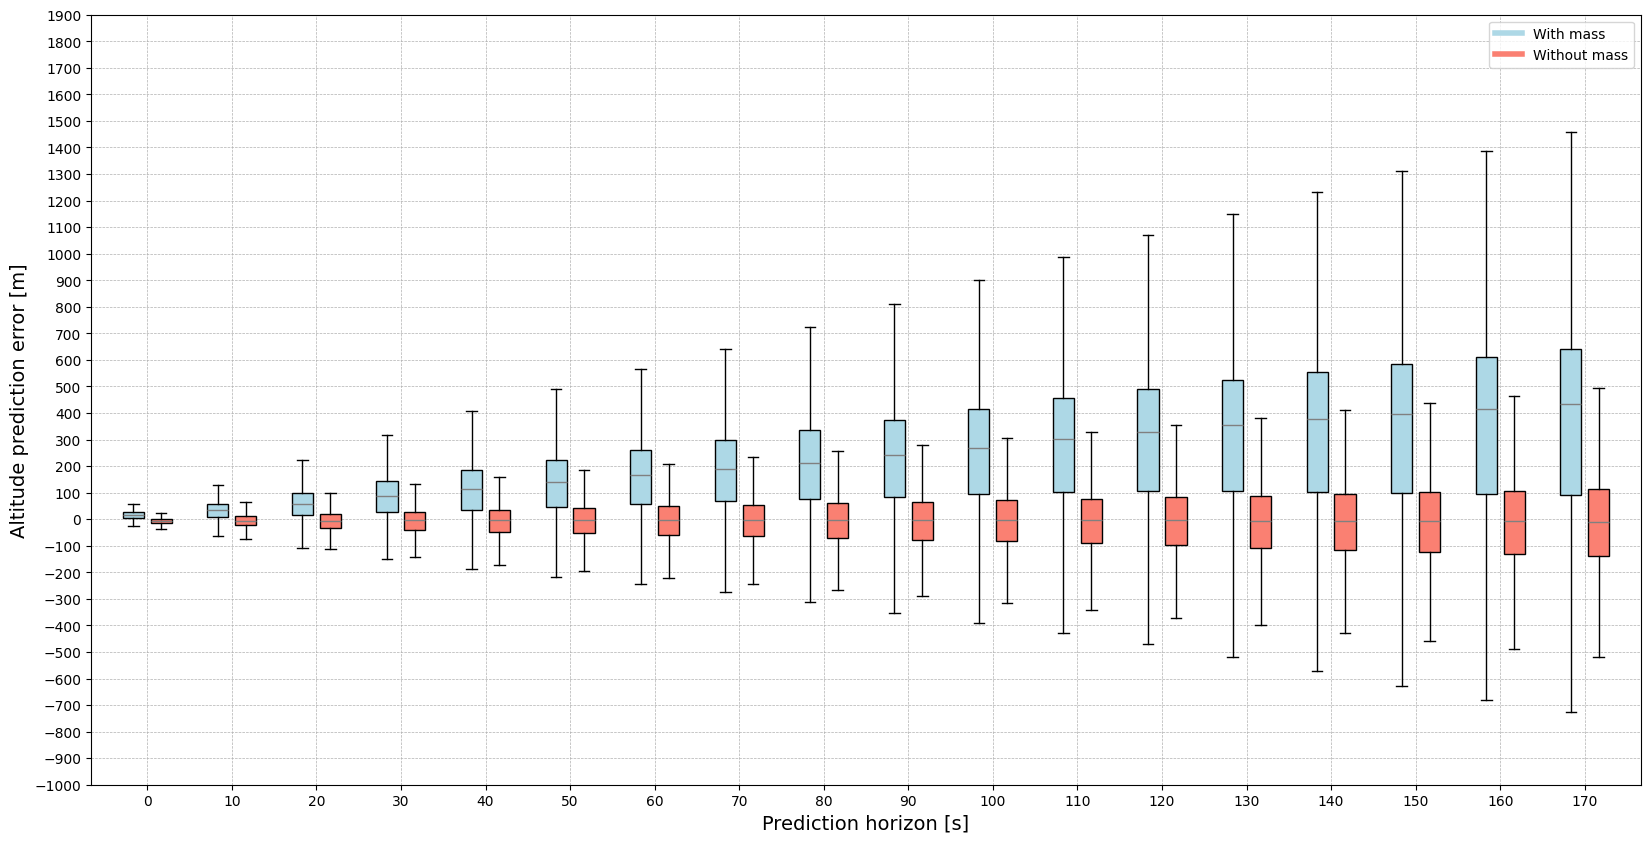

In [28]:
# Generate lists of lists for visualisation
group_with = [
    altitude_diff_with_mass_m[:, i]
    for i in range(altitude_diff_with_mass_m.shape[1])
]
group_without = [
    altitude_diff_without_mass_m[:, i]
    for i in range(altitude_diff_with_mass_m.shape[1])
]

# Plotting parameters
labels = ["With mass", "Without mass"]
colors = ["lightblue", "salmon"]
data_groups = [group_with, group_without]
width = 0.25  # Width of a boxplot

# Locations for boxplots
xlocations = np.arange(len(group_with))
group_positions = [
    xlocations - width / 2 - 0.04,
    xlocations + width / 2 + 0.04,
]

# Create plot
fig = plt.subplots(figsize=(20, 10))
for dag, pos, col in zip(data_groups, group_positions, colors):
    boxes = plt.boxplot(
        dag,
        positions=pos,
        widths=width,
        boxprops=dict(facecolor=col),
        medianprops=dict(color="grey"),
        patch_artist=True,
        showfliers=False,
    )

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("Altitude prediction error [m]", fontsize=14)
plt.xticks(
    ticks=range(0, 18, 1),
    labels=[str(i) for i in range(0, 180, 10)],
    rotation=0,
)
plt.yticks(ticks=np.arange(-1000, 2000, 100))

# Set plot grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Add legend
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in colors]
plt.legend(handles, labels)

plt.show()

***
### Analysis of position prediction error
***

##### Error calculation

In [44]:
# Extraction of latitudes and longitudes
pred_lat_with_mass = prediction_unscaled_with_mass[:, :, 0].flatten()
pred_lon_with_mass = prediction_unscaled_with_mass[:, :, 1].flatten()
pred_lat_without_mass = prediction_unscaled_without_mass[:, :, 0].flatten()
pred_lon_without_mass = prediction_unscaled_without_mass[:, :, 1].flatten()
test_lat = test_out_unscaled[:, :, 0].flatten()
test_lon = test_out_unscaled[:, :, 1].flatten()

# Latitude and longitude errors
lat_error_with_mass = (pred_lat_with_mass - test_lat).reshape(
    prediction_unscaled_with_mass.shape[0], 35
)[:, ::2]
lon_error_with_mass = (pred_lon_with_mass - test_lon).reshape(
    prediction_unscaled_with_mass.shape[0], 35
)[:, ::2]
lat_error_without_mass = (pred_lat_without_mass - test_lat).reshape(
    prediction_unscaled_without_mass.shape[0], 35
)[:, ::2]
lon_error_without_mass = (pred_lon_without_mass - test_lon).reshape(
    prediction_unscaled_without_mass.shape[0], 35
)[:, ::2]


# 2d position errors
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    haver_formula = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    )

    r = 6371
    dist = 2 * r * np.arcsin(np.sqrt(haver_formula))
    return dist


position_error_m_with_mass = (
    haversine(
        pred_lat_with_mass,
        pred_lon_with_mass,
        test_lat,
        test_lon,
    ).reshape(prediction_unscaled_with_mass.shape[0], 35)
    * 1000
)[:, ::2]

position_error_m_without_mass = (
    haversine(
        pred_lat_without_mass,
        pred_lon_without_mass,
        test_lat,
        test_lon,
    ).reshape(prediction_unscaled_without_mass.shape[0], 35)
    * 1000
)[:, ::2]

##### Visualisation latitude error

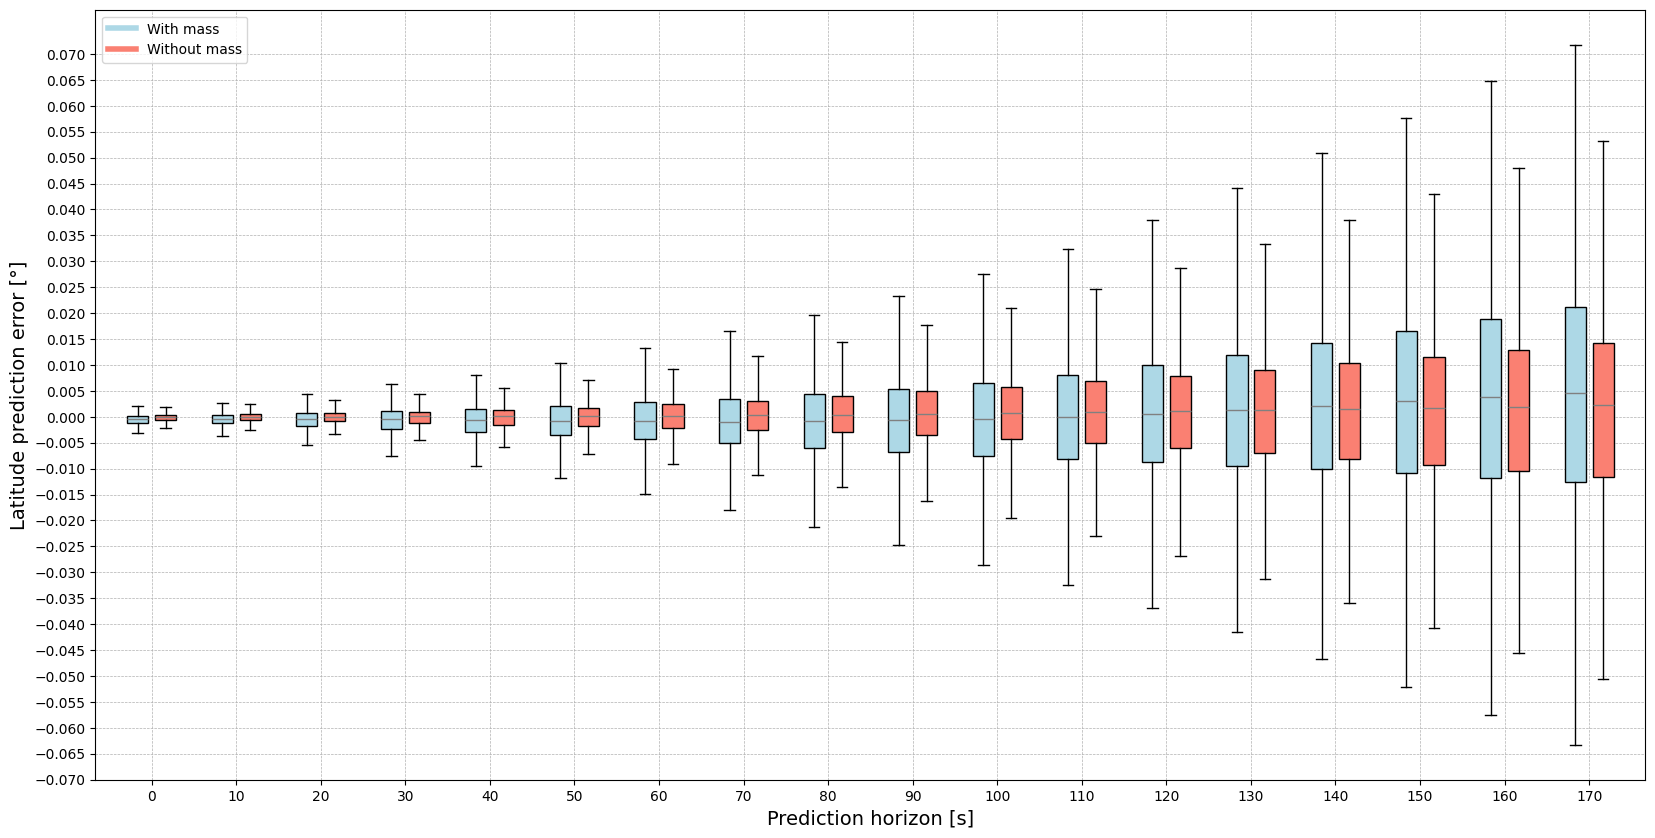

In [39]:
# Generate lists of lists for visualisation
group_with = [
    lat_error_with_mass[:, i] for i in range(lat_error_with_mass.shape[1])
]
group_without = [
    lat_error_without_mass[:, i] for i in range(lat_error_with_mass.shape[1])
]

# Plotting parameters
labels = ["With mass", "Without mass"]
colors = ["lightblue", "salmon"]
data_groups = [group_with, group_without]
width = 0.25  # Width of a boxplot

# Locations for boxplots
xlocations = np.arange(len(group_with))
group_positions = [
    xlocations - width / 2 - 0.04,
    xlocations + width / 2 + 0.04,
]

# Create plot
fig = plt.subplots(figsize=(20, 10))
for dag, pos, col in zip(data_groups, group_positions, colors):
    boxes = plt.boxplot(
        dag,
        positions=pos,
        widths=width,
        boxprops=dict(facecolor=col),
        medianprops=dict(color="grey"),
        patch_artist=True,
        showfliers=False,
    )

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("Latitude prediction error [°]", fontsize=14)
plt.xticks(
    ticks=range(0, 18, 1),
    labels=[str(i) for i in range(0, 180, 10)],
    rotation=0,
)
plt.yticks(ticks=np.arange(-0.07, 0.07, 0.005))

# Set plot grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Add legend
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in colors]
plt.legend(handles, labels)

plt.show()

##### Visualisation longitude error

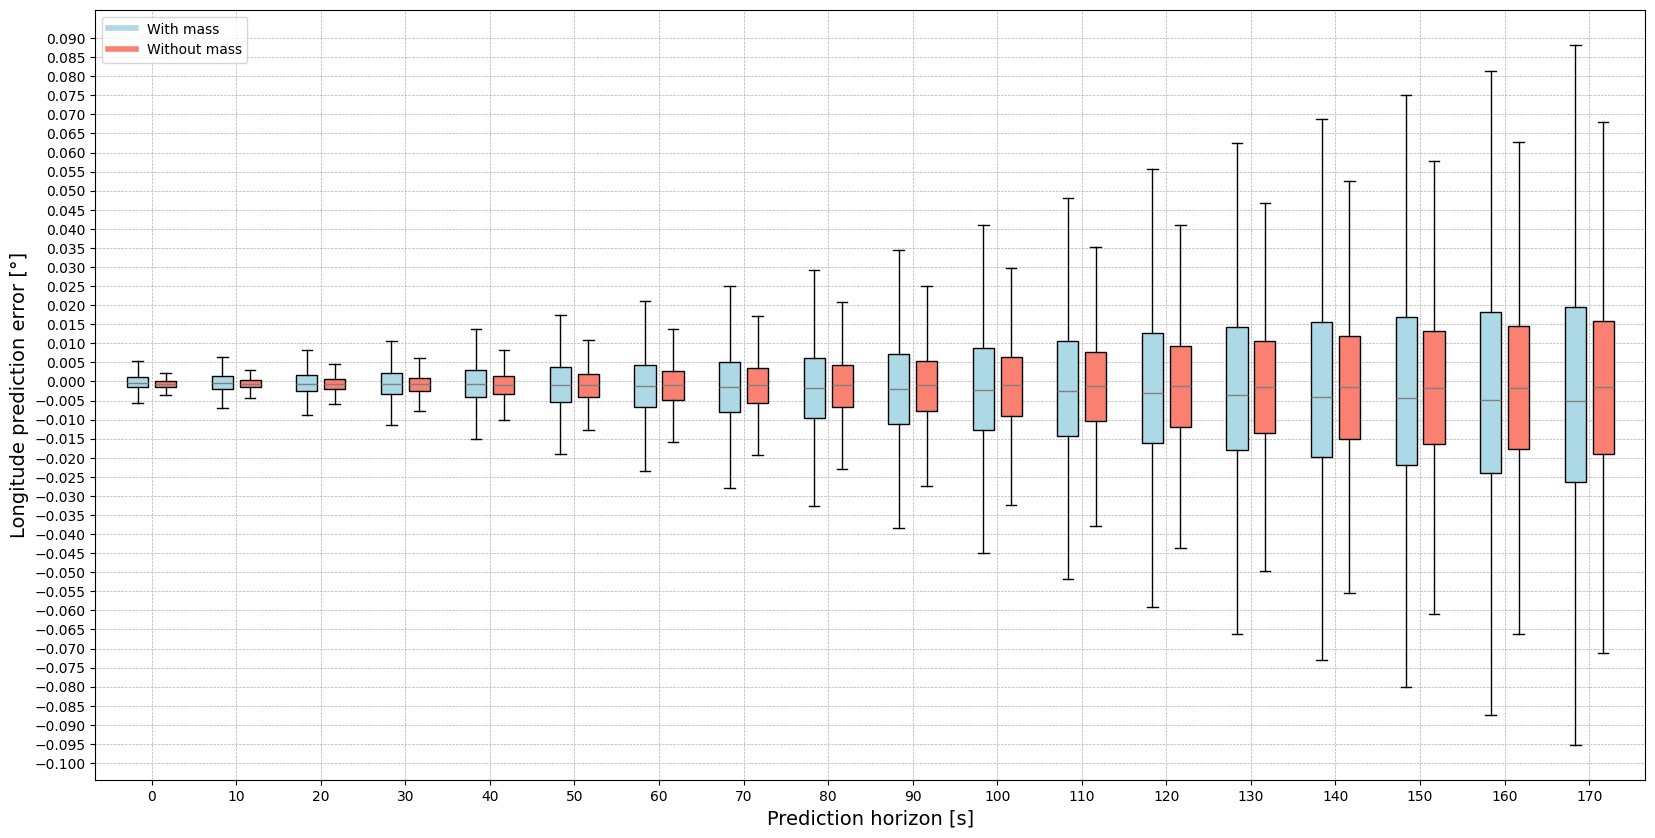

In [40]:
# Generate lists of lists for visualisation
group_with = [
    lon_error_with_mass[:, i] for i in range(lon_error_with_mass.shape[1])
]
group_without = [
    lon_error_without_mass[:, i] for i in range(lon_error_with_mass.shape[1])
]

# Plotting parameters
labels = ["With mass", "Without mass"]
colors = ["lightblue", "salmon"]
data_groups = [group_with, group_without]
width = 0.25  # Width of a boxplot

# Locations for boxplots
xlocations = np.arange(len(group_with))
group_positions = [
    xlocations - width / 2 - 0.04,
    xlocations + width / 2 + 0.04,
]

# Create plot
fig = plt.subplots(figsize=(20, 10))
for dag, pos, col in zip(data_groups, group_positions, colors):
    boxes = plt.boxplot(
        dag,
        positions=pos,
        widths=width,
        boxprops=dict(facecolor=col),
        medianprops=dict(color="grey"),
        patch_artist=True,
        showfliers=False,
    )

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("Longitude prediction error [°]", fontsize=14)
plt.xticks(
    ticks=range(0, 18, 1),
    labels=[str(i) for i in range(0, 180, 10)],
    rotation=0,
)
plt.yticks(ticks=np.arange(-0.1, 0.095, 0.005))

# Set plot grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Add legend
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in colors]
plt.legend(handles, labels)

plt.show()

##### Visualisation 2d position error

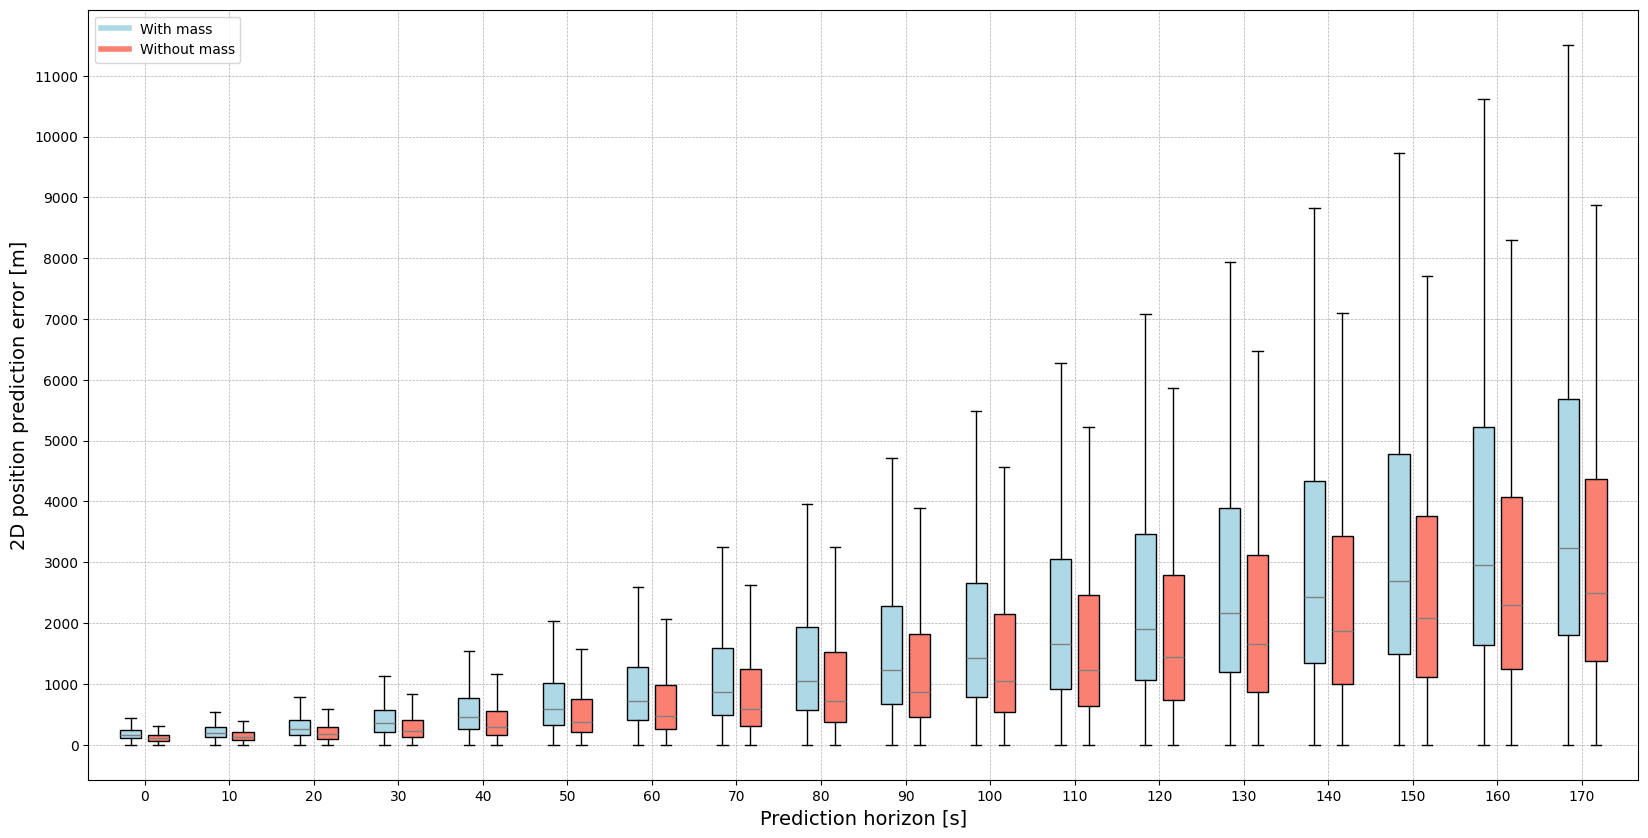

In [45]:
# Generate lists of lists for visualisation
group_with = [
    position_error_m_with_mass[:, i]
    for i in range(position_error_m_with_mass.shape[1])
]
group_without = [
    position_error_m_without_mass[:, i]
    for i in range(position_error_m_with_mass.shape[1])
]

# Plotting parameters
labels = ["With mass", "Without mass"]
colors = ["lightblue", "salmon"]
data_groups = [group_with, group_without]
width = 0.25  # Width of a boxplot

# Locations for boxplots
xlocations = np.arange(len(group_with))
group_positions = [
    xlocations - width / 2 - 0.04,
    xlocations + width / 2 + 0.04,
]

# Create plot
fig = plt.subplots(figsize=(20, 10))
for dag, pos, col in zip(data_groups, group_positions, colors):
    boxes = plt.boxplot(
        dag,
        positions=pos,
        widths=width,
        boxprops=dict(facecolor=col),
        medianprops=dict(color="grey"),
        patch_artist=True,
        showfliers=False,
    )

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("2D position prediction error [m]", fontsize=14)
plt.xticks(
    ticks=range(0, 18, 1),
    labels=[str(i) for i in range(0, 180, 10)],
    rotation=0,
)
plt.yticks(ticks=np.arange(0, 12000, 1000))

# Set plot grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Add legend
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in colors]
plt.legend(handles, labels)

plt.show()